In [78]:
# Import libraries
import pandas as pd
import duckdb as db
from duckdb.duckdb import DuckDBPyConnection

# Import custom functions
from generate import generate_continuous_sensors_event_data
from visualise import plot_sensor_data

In [3]:
# Generate a CSV file of sensor data
generate_continuous_sensors_event_data()

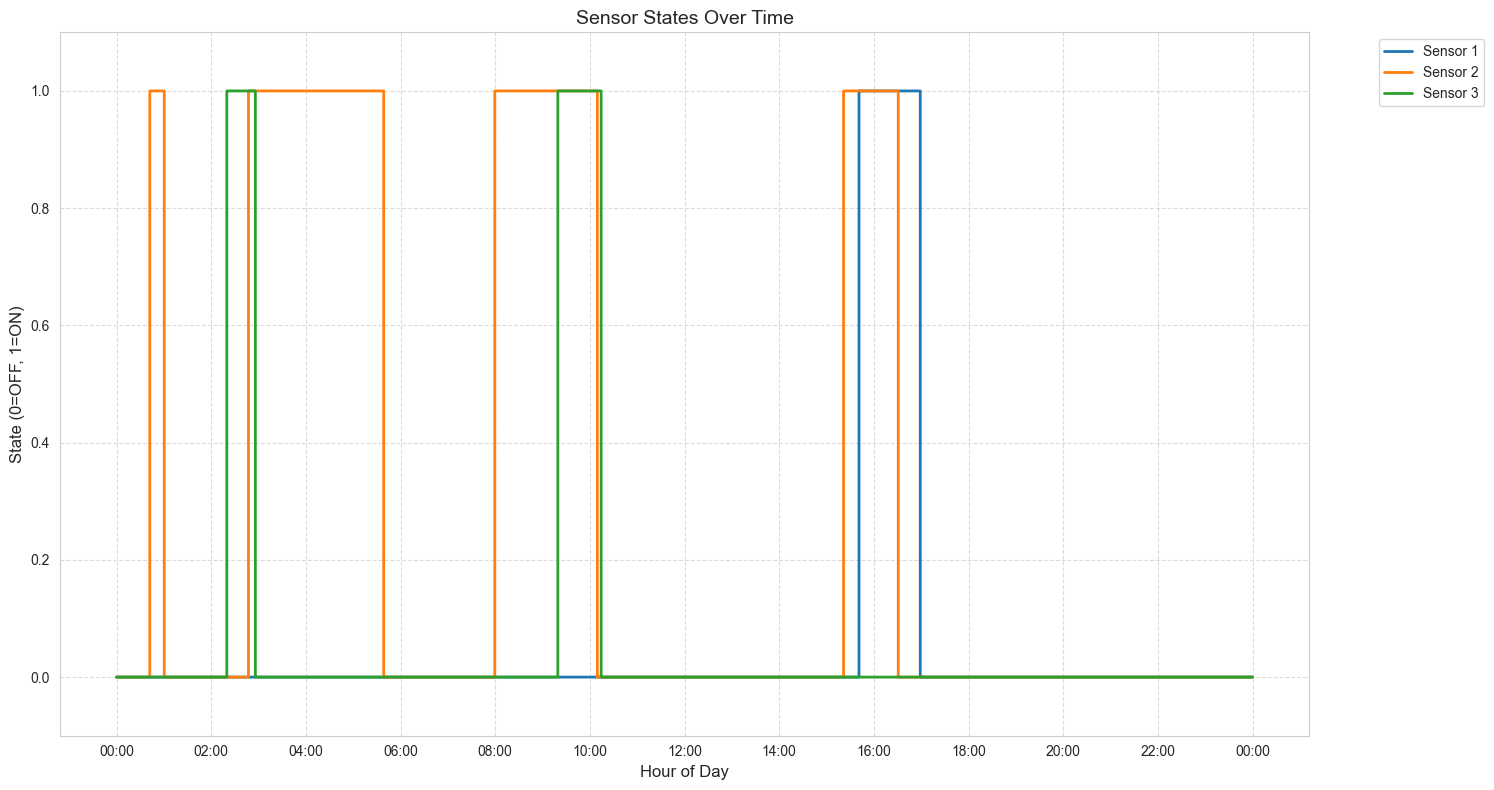

In [4]:
# Read the sensor data CSV file and create a column plot
df = pd.read_csv('sensor_data.csv')
plot_sensor_data(df)

In [5]:
# Create an in-memory connection to a DuckDB database
con = db.connect()

In [6]:
# Create a table of the sensor data to query
con.execute("CREATE TABLE sensor_data AS SELECT * FROM read_csv_auto('sensor_data.csv')")

In [7]:
# Describe the table schema
con.sql("DESCRIBE sensor_data").show()

┌──────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name  │ column_type │  null   │   key   │ default │  extra  │
│   varchar    │   varchar   │ varchar │ varchar │ varchar │ varchar │
├──────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ timestamp    │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ sensor_id    │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ sensor_value │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
└──────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘



In [8]:
# Query the table to view the first 10 rows
con.sql("SELECT * FROM sensor_data LIMIT 10").show()

┌─────────────────────┬───────────┬──────────────┐
│      timestamp      │ sensor_id │ sensor_value │
│      timestamp      │   int64   │    int64     │
├─────────────────────┼───────────┼──────────────┤
│ 2024-12-12 00:00:00 │         1 │            0 │
│ 2024-12-12 00:00:00 │         2 │            0 │
│ 2024-12-12 00:00:00 │         3 │            0 │
│ 2024-12-12 00:00:05 │         1 │            0 │
│ 2024-12-12 00:00:05 │         2 │            0 │
│ 2024-12-12 00:00:05 │         3 │            0 │
│ 2024-12-12 00:00:10 │         1 │            0 │
│ 2024-12-12 00:00:10 │         2 │            0 │
│ 2024-12-12 00:00:10 │         3 │            0 │
│ 2024-12-12 00:00:15 │         1 │            0 │
├─────────────────────┴───────────┴──────────────┤
│ 10 rows                              3 columns │
└────────────────────────────────────────────────┘



In [88]:
# Use window function to solve the gaps and islands problem with CTEs, the sensor_id, event_start_timestamp and event_end_timestamp columns should be returned
def get_events(con: DuckDBPyConnection, data_table_name: str, event_table_name) -> None:
    con.execute(f"""
    -- Create new table to store the sensor events aggreegated via the CTEs
    CREATE OR REPLACE TABLE {event_table_name} AS

        -- Create a row number for each sensor_id in ascending order of timestamp
        WITH sensor_data_with_row_number AS (
            SELECT *,
                ROW_NUMBER() OVER (PARTITION BY sensor_id ORDER BY timestamp) AS row_id
            FROM {data_table_name}
        ),
        -- Create an island_id for each sensor_id where the sensor_value is 1
        sensor_data_with_island_id AS (
            SELECT *,
                row_id - ROW_NUMBER() OVER (PARTITION BY sensor_id ORDER BY timestamp) AS island_id
            FROM sensor_data_with_row_number
            WHERE sensor_value = 1
        ),
        -- Aggregate the sensor data by sensor_id and island_id to get the event_start_timestamp, event_end_timestamp and event_duration
        sensor_data_event_agg AS (
            SELECT sensor_id,
                    MIN(timestamp) AS event_start_timestamp,
                    MAX(timestamp) AS event_end_timestamp,
                    event_end_timestamp - event_start_timestamp AS event_duration
            FROM sensor_data_with_island_id
            GROUP BY sensor_id, island_id
            ORDER BY sensor_id, event_start_timestamp
        )
        
    -- Populate the {event_table_name} table with the aggregated data from final CTE
    SELECT * FROM sensor_data_event_agg;
    """)

# Name the table to process data from, and the event table to output the results to
data_table_name = "sensor_data"
event_table_name = "sensor_events"

# Call the function to get the sensor events
get_events(con, data_table_name, event_table_name)

# Output the sensor events table
con.sql(f"SELECT * FROM {event_table_name}").show()

┌───────────┬───────────────────────┬─────────────────────┬────────────────┐
│ sensor_id │ event_start_timestamp │ event_end_timestamp │ event_duration │
│   int64   │       timestamp       │      timestamp      │    interval    │
├───────────┼───────────────────────┼─────────────────────┼────────────────┤
│         1 │ 2024-12-12 15:41:10   │ 2024-12-12 16:58:45 │ 01:17:35       │
│         2 │ 2024-12-12 00:42:10   │ 2024-12-12 01:00:25 │ 00:18:15       │
│         2 │ 2024-12-12 02:47:15   │ 2024-12-12 05:38:35 │ 02:51:20       │
│         2 │ 2024-12-12 07:59:30   │ 2024-12-12 10:09:25 │ 02:09:55       │
│         2 │ 2024-12-12 15:21:35   │ 2024-12-12 16:30:50 │ 01:09:15       │
│         3 │ 2024-12-12 02:19:50   │ 2024-12-12 02:55:55 │ 00:36:05       │
│         3 │ 2024-12-12 09:19:25   │ 2024-12-12 10:14:15 │ 00:54:50       │
└───────────┴───────────────────────┴─────────────────────┴────────────────┘



In [85]:
# Create a new table of sensor data, but where the timestamps that make up the first sensor_id have a gap of 60 seconds missing in the middle

con.execute("""
-- Create new table to store the original sensor data with a gap for the first sensor_id = 1 event
CREATE OR REPLACE TABLE sensor_data_gap AS
            
    -- Get the start and end timestamps of the first sensor event
    WITH first_sensor_event AS (
        SELECT
            FIRST (event_start_timestamp) AS event_start_timestamp,
            FIRST (event_end_timestamp) AS event_end_timestamp
        FROM sensor_events
        WHERE sensor_id = 1
        GROUP BY sensor_id
    ),
    -- Get the median timestamp from the raw sensor data in this range
    median_data_timestamp AS (
        SELECT
            MEDIAN (timestamp) as median_timestamp,
        FROM sensor_data
        WHERE
            sensor_id = 1 AND
            timestamp BETWEEN
                (SELECT event_start_timestamp FROM first_sensor_event) AND
                (SELECT event_end_timestamp FROM first_sensor_event)
    ),
    -- Get the min and max timestamps for the 30 second window around the median timestamp
    min_max_data_timestamps AS (
        SELECT
            median_timestamp - INTERVAL 30 SECONDS as min_timestamp,
            median_timestamp + INTERVAL 30 SECONDS as max_timestamp
        FROM median_data_timestamp
    ),
    -- Select data for all sensors, but excluding this 60 second gap for the first sensor_id = 1 event
    sensor_data_with_gap AS (
        SELECT *
        FROM sensor_data
        WHERE NOT (
            sensor_id = 1 AND
            timestamp BETWEEN (SELECT min_timestamp FROM min_max_data_timestamps) AND (SELECT max_timestamp FROM min_max_data_timestamps)
            )
    )
    
-- Populate the sensor_data_gap table with the data excluding the 60 second gap
SELECT * FROM sensor_data_with_gap;
""")

In [89]:
# See what impact this has on our event table now there is a gap in the first sensor_id = 1 event

# Name the table to process data from, and the event table to output the results to
data_table_name = "sensor_data_gap"
event_table_name = "sensor_events_gap"

# Call the function to get the sensor events
get_events(con, data_table_name, event_table_name)

# Output the sensor events table
con.sql(f"SELECT * FROM {event_table_name}").show()

┌───────────┬───────────────────────┬─────────────────────┬────────────────┐
│ sensor_id │ event_start_timestamp │ event_end_timestamp │ event_duration │
│   int64   │       timestamp       │      timestamp      │    interval    │
├───────────┼───────────────────────┼─────────────────────┼────────────────┤
│         1 │ 2024-12-12 15:41:10   │ 2024-12-12 16:58:45 │ 01:17:35       │
│         2 │ 2024-12-12 00:42:10   │ 2024-12-12 01:00:25 │ 00:18:15       │
│         2 │ 2024-12-12 02:47:15   │ 2024-12-12 05:38:35 │ 02:51:20       │
│         2 │ 2024-12-12 07:59:30   │ 2024-12-12 10:09:25 │ 02:09:55       │
│         2 │ 2024-12-12 15:21:35   │ 2024-12-12 16:30:50 │ 01:09:15       │
│         3 │ 2024-12-12 02:19:50   │ 2024-12-12 02:55:55 │ 00:36:05       │
│         3 │ 2024-12-12 09:19:25   │ 2024-12-12 10:14:15 │ 00:54:50       │
└───────────┴───────────────────────┴─────────────────────┴────────────────┘



In [91]:
def get_events_no_gap(con: DuckDBPyConnection, data_table_name: str, event_table_name: str, max_gap_seconds: int = 30) -> None:
    con.execute(f"""
    -- Create new table to store the sensor events aggregated via the CTEs
    CREATE OR REPLACE TABLE {event_table_name} AS
    
        -- Create a row number for each sensor_id in ascending order of timestamp
        WITH sensor_data_with_row_number AS (
            SELECT *,
                ROW_NUMBER() OVER (PARTITION BY sensor_id ORDER BY timestamp) AS row_id
            FROM {data_table_name}
            WHERE sensor_value = 1
        ),
        
        -- Calculate time difference to previous timestamp
        sensor_data_with_time_diff AS (
            SELECT *,
                timestamp - LAG(timestamp) OVER (PARTITION BY sensor_id ORDER BY timestamp) AS time_since_last_timestamp
            FROM sensor_data_with_row_number
        ),
        
        -- Create a unique event group identifier
        sensor_data_with_event_group AS (
            SELECT *,
                SUM(CASE WHEN time_since_last_timestamp > INTERVAL '{max_gap_seconds} seconds' OR time_since_last_timestamp IS NULL THEN 1 ELSE 0 END) 
                OVER (PARTITION BY sensor_id ORDER BY timestamp) AS event_group
            FROM sensor_data_with_time_diff
        ),
        
        -- Aggregate the sensor data by sensor_id and event_group
        sensor_data_event_agg AS (
            SELECT 
                sensor_id,
                MIN(timestamp) AS event_start_timestamp,
                MAX(timestamp) AS event_end_timestamp,
                event_end_timestamp - event_start_timestamp AS event_duration
            FROM sensor_data_with_event_group
            GROUP BY sensor_id, event_group
            ORDER BY sensor_id, event_start_timestamp
        )
    
    -- Populate the event table with the aggregated data from final CTE
    SELECT * FROM sensor_data_event_agg;
    """)

In [ ]:
# Try again only allowing a 30 second gap between timestamps to be considered the same event

# Name the table to process data from, and the event table to output the results to
data_table_name = "sensor_data_gap"
event_table_name = "sensor_events_no_gap"

# Call the function to get the sensor events
get_events_no_gap(con, data_table_name, event_table_name, max_gap_seconds=30)

# Output the sensor events table
con.sql(f"SELECT * FROM {event_table_name}").show()

┌───────────┬───────────────────────┬─────────────────────┬────────────────┐
│ sensor_id │ event_start_timestamp │ event_end_timestamp │ event_duration │
│   int64   │       timestamp       │      timestamp      │    interval    │
├───────────┼───────────────────────┼─────────────────────┼────────────────┤
│         1 │ 2024-12-12 15:41:10   │ 2024-12-12 16:19:25 │ 00:38:15       │
│         1 │ 2024-12-12 16:20:30   │ 2024-12-12 16:58:45 │ 00:38:15       │
│         2 │ 2024-12-12 00:42:10   │ 2024-12-12 01:00:25 │ 00:18:15       │
│         2 │ 2024-12-12 02:47:15   │ 2024-12-12 05:38:35 │ 02:51:20       │
│         2 │ 2024-12-12 07:59:30   │ 2024-12-12 10:09:25 │ 02:09:55       │
│         2 │ 2024-12-12 15:21:35   │ 2024-12-12 16:30:50 │ 01:09:15       │
│         3 │ 2024-12-12 02:19:50   │ 2024-12-12 02:55:55 │ 00:36:05       │
│         3 │ 2024-12-12 09:19:25   │ 2024-12-12 10:14:15 │ 00:54:50       │
└───────────┴───────────────────────┴─────────────────────┴────────────────┘

In [95]:
# Try again allowing a 3 hour (30 * 60 * 60 second) gap between timestamps to be considered the same event

# Name the table to process data from, and the event table to output the results to
data_table_name = "sensor_data_gap"
event_table_name = "sensor_events_gap_big"

# Call the function to get the sensor events
get_events_no_gap(con, data_table_name, event_table_name, max_gap_seconds=3*60*60)

# Output the sensor events table
con.sql(f"SELECT * FROM {event_table_name}").show()

┌───────────┬───────────────────────┬─────────────────────┬────────────────┐
│ sensor_id │ event_start_timestamp │ event_end_timestamp │ event_duration │
│   int64   │       timestamp       │      timestamp      │    interval    │
├───────────┼───────────────────────┼─────────────────────┼────────────────┤
│         1 │ 2024-12-12 15:41:10   │ 2024-12-12 16:58:45 │ 01:17:35       │
│         2 │ 2024-12-12 00:42:10   │ 2024-12-12 10:09:25 │ 09:27:15       │
│         2 │ 2024-12-12 15:21:35   │ 2024-12-12 16:30:50 │ 01:09:15       │
│         3 │ 2024-12-12 02:19:50   │ 2024-12-12 02:55:55 │ 00:36:05       │
│         3 │ 2024-12-12 09:19:25   │ 2024-12-12 10:14:15 │ 00:54:50       │
└───────────┴───────────────────────┴─────────────────────┴────────────────┘

